## Geopandas Examples

In [1]:
import os

import geopandas as gpd
import fiona
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Read a shapefile

In [ ]:
# In NAD83
shp_path = os.path.join(os.environ["DATA_DIR"], 'us_states', 'tl_2014_us_state.shp')

states_df = gpd.read_file(shp_path)
states_df.head(20)

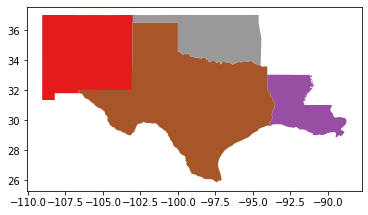

In [6]:
states_df[states_df.STUSPS.isin(['TX', 'OK', 'NM', 'LA'])].plot(cmap="Set1")

## Examine Metadata

In [11]:
states_df.head(5).geom_type

0         Polygon
1    MultiPolygon
2         Polygon
3         Polygon
4         Polygon
dtype: object

In [12]:
states_df.crs

{'init': 'epsg:4269'}

## Transformations/Reprojections

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


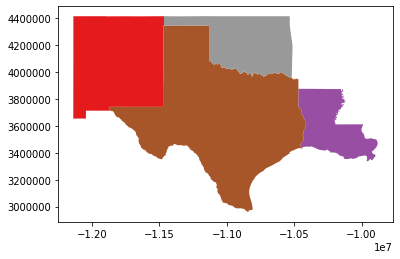

In [5]:
# Mercator: https://spatialreference.org/ref/epsg/3395/
#merc = states_df.to_crs({'init': 'epsg:3395'})
merc = states_df[states_df.STUSPS.isin(['TX', 'OK', 'NM', 'LA'])].to_crs(epsg=3395)

merc.plot(cmap="Set1")

## Spatial Join

In [ ]:
# In NAD27: EPSG:4267
shp_path2 = os.path.join(os.environ["DATA_DIR"], 'roads', 'roads.shp')

roads_df = gpd.read_file(shp_path2)
roads_df.head()

## Standardize to WGS84, EPSG:4326

In [ ]:
states_wgs84_df = states_df.loc[:, ['STATEFP', 'STUSPS', 'NAME', 'geometry']].copy().to_crs(epsg=4326)
roads_wgs84_df = roads_df.copy().to_crs(epsg=4326)

In [12]:
roads_states_df = gpd.sjoin(roads_wgs84_df, states_wgs84_df, how='inner', op='within')

In [ ]:
roads_states_df.head()

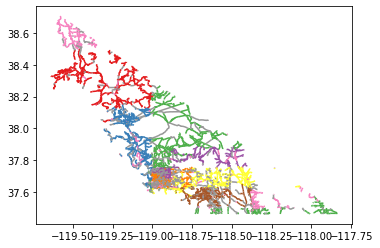

In [13]:
roads_states_df.plot(cmap="Set1")

## Overlaps Example via Spatial Join

In [13]:
%%time

# In WGS84: EPSG:4326
layers = ['Counties_US_WGS84', 'NM_township']

gdb_path = os.path.join(os.environ["DATA_DIR"], 'landgrid', 'DI_basemaps_WGS84.gdb')

counties_df = gpd.read_file(gdb_path, layer='Counties_US_WGS84')
nm_twp_df = gpd.read_file(gdb_path, layer='NM_township')

# pre-generate sindex if it doesn't already exist
nm_twp_df.sindex

CPU times: user 6.06 s, sys: 51.5 ms, total: 6.11 s
Wall time: 6.1 s


In [14]:
%%time

ovlaps_df = gpd.sjoin(nm_twp_df, counties_df, how='inner', op='intersects')

CPU times: user 1.51 s, sys: 60 µs, total: 1.51 s
Wall time: 1.51 s


### Implement String Aggregation using Pandas
- [Reference](https://stackoverflow.com/questions/17841149/pandas-groupby-how-to-get-a-union-of-strings)

In [ ]:
%%time

ovlaps_agg_df = ovlaps_df.loc[:, ['TWPCODE', 'TWPLabel', 'County_Name']].copy()

# ovlaps_join_df = (ovlaps_agg_df
#                   .groupby('TWPLabel', sort=False)
#                   .filter(lambda x: len(x['County_Name']) > 2)  # like HAVING
#                   .groupby('TWPLabel', sort=False)
#                   .aggregate({'TWPCODE': 'first',
#                               'County_Name': ','.join})
#                  )

#Pandas 0.25.0
ovlaps_join_df = (ovlaps_agg_df
                  .groupby('TWPLabel', sort=False)
                  .filter(lambda x: len(x['County_Name']) > 2)  # like HAVING
                  .groupby('TWPLabel', sort=False)
                  .aggregate(TWPCODE=('TWPCODE', 'first'),
                             County_Count=('County_Name', 'size'),
                             County_Overlaps=('County_Name', ','.join)))

ovlaps_join_df.reset_index()

## Dissolve Example

In [29]:
# In WGS84: EPSG:4326
# For Texas_Abstracts, dissolve (Township, Block) => Block
# For Ohio_Sections, dissolve (COUNTY, TOWNSHIP) => Municipality
# For Ohio_Sections, dissolve (COUNTY, TOWNSHIP, TWP, TNS, RGE, REW) => Township
# For Ohio_Sections, dissolve (COUNTY, TOWNSHIP, TWP, TNS, RGE, REW) => Section

layers = ['Ohio_Sections', 'Texas_Abstracts', 'Ohio_Sections']
gdb_path = os.path.join(os.environ["DATA_DIR"], 'landgrid', 'DI_basemaps_WGS84.gdb')

ohio_df = gpd.read_file(gdb_path, layer='Ohio_Sections')

In [31]:
ohio_df.columns

Index(['SUBDIV_NM', 'TWP', 'TNS', 'RGE', 'REW', 'SEC', 'QTR_TWP', 'ALLOTMENT',
       'TRACT', 'LOT', 'DIVISION', 'FRACTION', 'COUNTY', 'TOWNSHIP',
       'SURVEY_TYP', 'Shape_Leng', 'ObjectID', 'VMSLOT', 'OTHER_SUB',
       'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

In [32]:
%%time

ohio_muni_df = ohio_df.dissolve(by=['COUNTY', 'TOWNSHIP'], aggfunc='first')

CPU times: user 13.7 s, sys: 6 µs, total: 13.7 s
Wall time: 13.8 s


In [ ]:
ohio_muni_df.index

In [ ]:
ohio_muni_df.plot()

ohio_muni_df.head()